# NN with PyTorch: regression

## Objective

Set up a simple feed-forward for a regression problem on a socio-economic database.

We use a well-studied California housing dataset to predict the price. 

This dataset  describes the median house value for California districts. The target variable is the median house value and there are 8 input features, each describing something about the target. They are, namely,

- MedInc: median income in block group
- HouseAge: median house age in block group
- AveRooms: average number of rooms per household
- AveBedrms: average number of bedrooms per household
- Population: block group population
- AveOccup: average number of household members
- Latitude: block group centroid latitude
- Longitude: block group centroid longitude

This data is special because the input data has vastly different scales. For example, the number of rooms per house is usually small but the population per block group is usually large. Moreover, most features should be positive but the longitude must be negative (in California). Handling such diversity of data is a challenge for some machine learning models.

In [6]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
print(data.feature_names)

 
X, y = data.data, data.target

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


## 1. Build the model

Since this is a regression problem, there isnNo need for an activation in last layer.
We will use a classical pyramidal architecture, where the number of neurons in each layer decreases as the network progresses to the output: 8-24-12-6-1. Here, 8 correponds to the input layer dimension, and 1 to the output, which is scalar.



In [2]:
import torch.nn as nn

# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

## 2. Define Loss and Optimizer

For real-valued response, we use a standard choice of
- `MSELoss`, and 
- `Adam` optimizer.

In [3]:
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## 3. Train the model

Set up training loop with train-test split, to evaluate the model.

We use `tqdm` to set up a progress bar, and we report the MSE at each iteration. To enable the bar, set `disable = False` in the `tqdm` command.

In [4]:
import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split

# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.float32).reshape(-1, 1)

# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Keep the best model
best_mse = np.inf   # initialize to infinity
best_weights = None
history = []

# Training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

MSE: 0.54
RMSE: 0.73


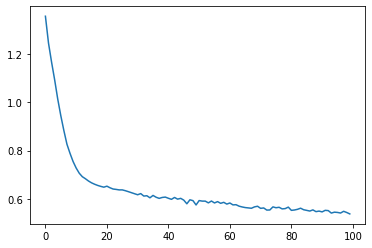

In [5]:
import matplotlib.pyplot as plt

print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

## Data Preprocessing

We observe a high value of the RMSE, equal to $0.73.$ This is due to the diversity of the feature scales. Some have a narrow range and some are wide. Others are small but positive while some are very negative. This can be observed by calculating some summary statistics.

To improve the precision, we need scale the input variables.

In [11]:
# compute summary statistics
import pandas as pd
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target variable to the dataframe
df['target'] = data.target

# Print the first 5 rows of the dataframe
print(df.head())
# Print all the summary statistics
df.describe()

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### Scaling the inout variables

A commonly used scaling, that preserves the signs of the variables, is the standard scaler. This is defined as

$$ z = \frac{x – \bar{x}}{\sigma_x}, $$

where $\bar{x}$ is the average of the variable $x,$  and $\sigma_x$ is its standard deviation. This way, every transformed feature is centered around 0 and in a narrow range, such that around 70% of the samples are between -1 and  +1. This can help the machine learning model to converge.

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# Read data afresh
data = fetch_california_housing()
X, y = data.data, data.target

# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

Note that standard scaler is applied _after_ train-test split. The `StandardScaler` above is fitted on the training set but applied on both the training and test set. You must not apply the standard scaler to all data because nothing from the test set should be hinted to the model. Otherwise we are introducing _data leakage_.

Now we rerun the model training.

MSE: 0.31
RMSE: 0.55


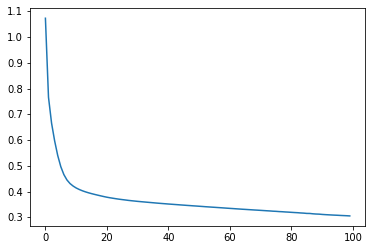

In [15]:
# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
#loss_fn = nn.L1Loss()  # mean absolute percentage error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

Note that the converegence has improves.

1. the descent is much smoother
2. a much lower value of MSE is obtained. 


### Evaluate the model on test data

We can now test the predictive precision of the model, by applying iy to the unseen test data.

In [18]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

[   5.0222   37.        6.2       0.952   805.        3.22     37.36
 -122.09  ] -> [2.499951] (expected [5.00001])
[   3.1          30.            4.97749196    0.90675241  886.
    2.8488746    36.76       -119.73      ] -> [0.8705448] (expected [0.713])
[   4.1016       14.           20.93939394    3.66666667  141.
    2.13636364   39.2        -120.15      ] -> [1.5833384] (expected [2.833])
[  15.0001       46.            8.3655914     0.96774194  238.
    2.55913978   34.08       -118.43      ] -> [4.9034395] (expected [5.00001])
[ 1.60090000e+00  4.40000000e+01  3.11584554e+00  1.09853529e+00
  2.81300000e+03  3.74567244e+00  3.77800000e+01 -1.22230000e+02] -> [1.7868751] (expected [1.181])


## Conclusions

There is still room to improve the model and the training.

1. Try an L1 type of loss function, eg. MAPE or MAE.
2. Modify the architecture of the network.